In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

import pyswarms as ps

from utils import dt2int
from torchdiffeq import odeint
from collections import namedtuple
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
# better plots
sns.set_style('whitegrid')

In [3]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [4]:
# read data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

In [5]:
# load parameters
orig_params = pd.read_csv("parameters/vpatient_params.csv")
mean_params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()
mean_params = mean_params.rename(lambda x: x.replace(" ", ""))
adult_params = orig_params[orig_params.Name.str.contains("adult")]

min_params = adult_params.min()
max_params = adult_params.max()

def get_param(p, p_min, p_max):
    return ((np.tanh(p) + 1) / 2) * (p_max - p_min) + p_min

In [6]:
in_time = data_t
# in_CHO = data_CHO
in_CHO = data_CHO / 2
# in_insulin = data_insulin
in_insulin = np.where(data_insulin > data_insulin[0], data_insulin / 2, data_insulin)

def ode(t, x, p):
    # instantiate derivatives
    dxdt = np.zeros(13)

    # destructure params
    _kabs, _kmax, _kmin, _k2, _k1, _ki, _kp2, _kp3, _ke1, _kp1 = p

    # fixed parameters
    params = mean_params
    kabs = get_param(_kabs, min_params["kabs"], max_params["kabs"])
    kmax = get_param(_kmax, min_params["kmax"], max_params["kmax"])
    kmin = get_param(_kmin, min_params["kmin"], max_params["kmin"])
    k2 = get_param(_k2, min_params["k2"], max_params["k2"])
    k1 = get_param(_k1, min_params["k1"], max_params["k1"])
    ki = get_param(_ki, min_params["ki"], max_params["ki"])
    kp2 = get_param(_kp2, min_params["kp2"], max_params["kp2"])
    kp3 = get_param(_kp3, min_params["kp3"], max_params["kp3"])
    ke1 = get_param(_ke1, min_params["ke1"], max_params["ke1"])
    kp1 = get_param(_kp1, min_params["kp1"], max_params["kp1"])

    # get current action
    t_mask = np.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = kmin + (kmax - kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar))
            - np.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = kmax

    # stomach liquid
    dxdt[1] = kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - kabs * x[2]

    # Rate of appearance
    Rat = params.f * kabs * x[2] / params.BW
    # Glucose Production
    EGPt = kp1 - kp2 * x[3] - kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - k1 * x[3] + k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + k1 * x[3] - k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -ki * (x[7] - It)

    dxdt[8] = -ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt

In [7]:
# initial conditions
x_0 = mean_params.iloc[2:15].to_numpy()

# timespan
tspan = (data_t[0], data_t[-1])
t_eval = data_t

In [8]:
# initial parameter guess
p_guess = np.array([
    mean_params["kabs"], 
    mean_params["kmax"],
    mean_params["kmin"],
    mean_params["k2"],
    mean_params["k1"],
    mean_params["ki"],
    mean_params["kp2"],
    mean_params["kp3"],
    mean_params["ke1"],
    mean_params["kp1"]
])

In [9]:
# compute loss for one parameter set
def loss(p):
    try:
        sol = solve_ivp(ode, tspan, x_0, t_eval=t_eval, args=(p,), method="BDF")
        sol_CGM = sol.y[12] / mean_params["Vg"]

        try:
            return mean_squared_log_error(sol_CGM, data_CGM)
        except:
            return 1e10

    except:
        print(p)


# evaluate the loss function for multiple parameter sets
def evaluate(p_set):
    with mp.Pool() as p:
        losses = p.map(loss, p_set)
    losses = np.array(losses)
    return losses

# Optimization

In [10]:
# PSO algorithm setup
# bounds = (p_min, p_max)  # define bounds for each parameter
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}

# instantiate PSO optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=len(p_guess), options=options) #, bounds=bounds)

# perform optimization
best_cost, best_params = optimizer.optimize(evaluate, iters=500)

# print results
print("Best cost:", best_cost)
print("Best parameters:", best_params)

2023-05-04 03:10:31,877 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.global_best:  98%|█████████▊|490/500, best_cost=0.0112/home2/vishva.saravanan/miniconda3/envs/v/lib/python3.10/site-packages/scipy/integrate/_ivp/bdf.py:407: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.0112
2023-05-04 03:18:51,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.011214003567884401, best pos: [ 1.704388    0.38280783  1.04447296  1.02285372 -0.67014297  1.02258169
  0.13186495  0.46723555  2.1008251  -0.22651689]


Best cost: 0.011214003567884401
Best parameters: [ 1.704388    0.38280783  1.04447296  1.02285372 -0.67014297  1.02258169
  0.13186495  0.46723555  2.1008251  -0.22651689]


In [11]:
np.savetxt("results/best_params.csv", best_params, delimiter=",")
print("Done. Saved to results/best_params.csv")

Done. Saved to results/best_params.csv


Done. Saved to results/fit.png


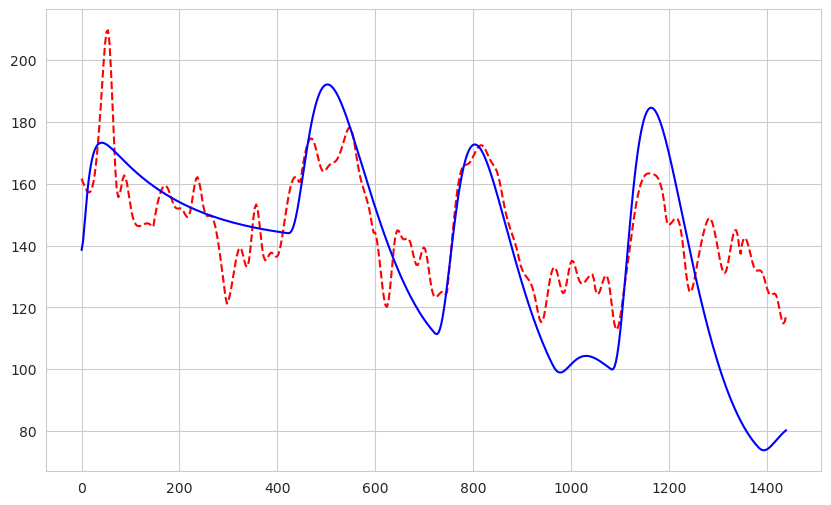

In [12]:
sol = solve_ivp(ode, tspan, x_0, t_eval=t_eval, args=(best_params,))
sol_g = solve_ivp(ode, tspan, x_0, t_eval=t_eval, args=(p_guess,))

sol_t = sol.t
sol_CGM = sol.y[12] / mean_params["Vg"]

plt.figure(figsize=(10, 6))
plt.plot(data_t, data_CGM, "r--")
plt.plot(sol_t, sol_CGM, "b")
plt.savefig("results/fit.png")
print("Done. Saved to results/fit.png")